In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import chi2_contingency, norm, shapiro
from tqdm.auto import tqdm
from urllib.parse import urlencode

plt.style.use('ggplot')

# Задание 1. A/B–тестирование

Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [2]:
# Function to get df by Link from Yandex Disk
def get_ya_disk_df(url, sep):
    
    start_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    full_url = start_url + urlencode(dict(public_key=url))
    request = requests.get(full_url)
    final_url = json.loads(request.text)['href']
    
    df = pd.read_csv(final_url, sep=sep)
    return df

In [3]:
# Загружаем файлы при помощи созданной функции
groups = get_ya_disk_df("https://disk.yandex.ru/d/58Us0DWOzuWAjg", sep=';')
groups_add = get_ya_disk_df("https://disk.yandex.ru/d/3aARY-P9pfaksg", sep=',')
active_studs = get_ya_disk_df("https://disk.yandex.ru/d/prbgU-rZpiXVYg", sep=';')
checks = get_ya_disk_df("https://disk.yandex.ru/d/84hTmELphW2sqQ", sep=';')

In [4]:
groups[:2]

,id,grp
0,1489,B
1,1627,A


In [5]:
groups_add[:2]

,id,grp
0,5694584,B
1,5694830,B


In [6]:
active_studs[:2]

,student_id
0,581585
1,5723133


In [7]:
checks[:2]

,student_id,rev
0,1627,990.0
1,3185,690.0


In [8]:
# Rename id columns for merge
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

<b>Вопросы</b>

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

# Проверка данных

In [9]:
groups.id.shape[0], groups_add.id.shape[0], active_studs.id.shape[0], checks.id.shape[0]

(74484, 92, 8341, 541)

In [10]:
# All checks in active_studs?

checks[checks.id.isin(active_studs.id)].shape[0]

392

Из 541 чека в активных пользователях оказались только 392.<br />
Проверим, есть ли оставшиеся 149 id, сделавших покупки, в groups и groups_add

<img src="https://www.storytourist.com/wp-content/uploads/2020/10/sherlock-holmes-4470682_1920-1.jpg" width="400" height="400" />

In [11]:
checks[checks.id.isin(groups.id)].shape[0], checks[checks.id.isin(groups_add.id)].shape[0]

(540, 1)

Чеки найдены! Ура!

In [12]:
# All ids unique or we've got duplicates?

groups.id.is_unique, groups_add.id.is_unique, active_studs.id.is_unique, checks.id.is_unique

(True, True, True, True)

Во всех таблицах нет дубликатов. Один id - одна активность, одна покупка в чеках

Все id уникальны

<img src="https://store.ubi.com/dw/image/v2/ABBS_PRD/on/demandware.static/-/Sites-masterCatalog/default/dw1b205326/images/large/56c4948888a7e300458b47de-3.jpg?sw=783&sh=440&sm=fit" width="600" height="600" />

In [13]:
groups.isna().sum(), groups_add.isna().sum(), active_studs.isna().sum(), checks.isna().sum()

(id     0
 grp    0
 dtype: int64,
 id     0
 grp    0
 dtype: int64,
 id    0
 dtype: int64,
 id     0
 rev    0
 dtype: int64)

Пропусков в данных также нет

В groups_add всего 92 записи.<br />При бОльшем количестве можно было бы провести AA-тесты для проверки чистоты данных и отсутствии изменчивости по дням.

In [14]:
# Merge groups and groups_add

groups_full = groups.merge(groups_add, how='outer')

# Check if we saved all ids
groups.shape[0] + groups_add.shape[0] == groups_full.shape[0]

True

In [15]:
# Mark active users.
active_studs['active'] = 1

# Merge groups with activity. Mark as 0 non-active users
active_full = groups_full.merge(active_studs, how='left')
active_full.active.fillna(0, inplace=True)
active_full.head()

,id,grp,active
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


In [16]:
# Check if we've got all ids from active_studs. --> All
active_studs[~active_studs.id.isin(active_full.id)]

,id,active


In [17]:
# Mark paying users
checks['bought'] = 1

# Merge groups with checks. Mark as 0 users with no purchases
money_full = groups_full.merge(checks, how='left')
money_full = money_full.merge(active_studs, how='left')
money_full.active.fillna(0, inplace=True)

In [18]:
# All checks in money_full? --> Yep
checks[~checks.id.isin(money_full.id)]

,id,rev,bought


# Какие метрики проверяем

У нас есть 2 группы, информация об активности и чеках.

Нас в первую очередь интересуют деньги<br/>
Поэтому проверим, есть ли различия по группам в <b>ARPU и ARPPU</b>

Также посмотрим на <b>конверсии <br />
1) в активность<br />
2) в покупку<br />
3) из активности в покупку (хотя, как мы помним, в чеках есть экстра id, которых нет в таблице активности)</b>

In [19]:
metrics = pd.DataFrame(columns=['total_users', 'active_users', 'paying_users', 'money',
                       'ARPU', 'ARPPU', 'ARPAU', 'CR_activity', 'CR_purchase', 'CR_activity_purchase'],
                       index=['A', 'B'])

In [20]:
# Create metrics DF

metrics['total_users'] = money_full.grp.value_counts()
metrics['active_users'] = money_full.query('active == 1').grp.value_counts()
metrics['paying_users'] = money_full.query('bought == 1').grp.value_counts()

metrics['money'] = money_full.groupby('grp').rev.sum()
metrics['ARPU'] = metrics['money'] / metrics['total_users']
metrics['ARPPU'] = metrics['money'] / metrics['paying_users']
metrics['ARPAU'] = metrics['money'] / metrics['active_users']

metrics['CR_activity'] = metrics['active_users'] / metrics['total_users']
metrics['CR_purchase'] = metrics['paying_users'] / metrics['total_users']
metrics['CR_activity_purchase'] = metrics['paying_users'] / metrics['active_users']

In [21]:
metrics

,total_users,active_users,paying_users,money,ARPU,ARPPU,ARPAU,CR_activity,CR_purchase,CR_activity_purchase
A,14693,1538,107,92096.0000,6.268019,860.710280,59.880364,0.104676,0.007282,0.069571
B,59883,6803,434,481230.0036,8.036171,1108.824893,70.737910,0.113605,0.007247,0.063795


In [22]:
# Check money distribution in groups A and B

money_A = money_full.query('bought == 1 and grp=="A"')
money_B = money_full.query('bought == 1 and grp=="B"')

money_A_active = money_full.query('active == 1 and bought == 1 and grp=="A"')
money_B_active = money_full.query('active == 1 and bought == 1 and grp=="B"')

money_full_A = money_full.query('grp=="A"').fillna(0)
money_full_B = money_full.query('grp=="B"').fillna(0)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


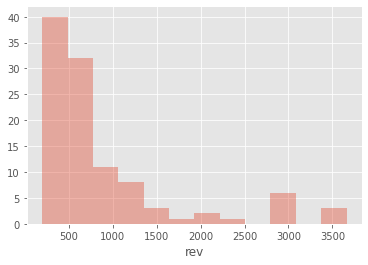

In [23]:
# Check distribution. Quite not normal..

sns.distplot(money_A.rev, kde=False)

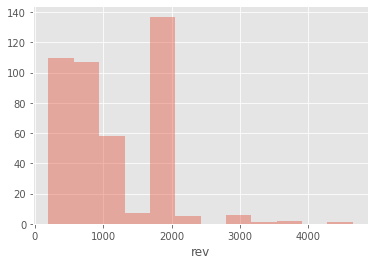

In [24]:
sns.distplot(money_B.rev, kde=False)

Ух сколько стало чеков по 2000!<br/>
Целевой группе наверное предложили купить на 2000 для повышенного кэшбека (у Тинькофф-Яндекс Маркет как раз часто такое)

<img src="https://images-na.ssl-images-amazon.com/images/S/pv-target-images/a5cbdc3935c156f6d776578593a2704be813053ea3348b54e29b218e2ea3f165._UY500_UX667_RI_V_TTW_.jpg" width="600" height="600" />


In [25]:
# Check normality with Shapiro-Wilk test
# p-value > 0.05 => normal distribution

shapiro(money_A.rev), shapiro(money_B.rev)

(ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13),
 ShapiroResult(statistic=0.8672363758087158, pvalue=8.947892893418603e-19))

<img src="https://runsmartonline.com/articles/prevention/wp-content/uploads/2016/09/runsmart-youre-not-normal.jpg" width="800" height="800" />

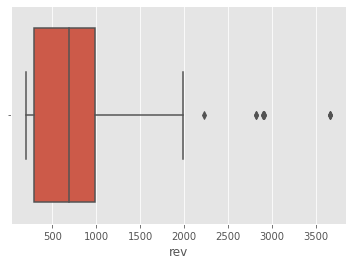

In [26]:
#  Check outliers

sns.boxplot(x=money_A['rev'])

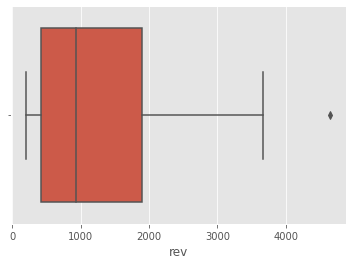

In [27]:
sns.boxplot(x=money_B['rev'])

Есть небольшие выбросы. Хвост не длинный, поэтому возьмем 1.5 межквартильного размаха

In [28]:
# Create duplicated DFs for following cleaning
money_A_no_outliers = money_A.copy()
money_B_no_outliers = money_B.copy()

money_A_active_no_outliers = money_A_active.copy()
money_B_active_no_outliers = money_B_active.copy()

money_A.rev.min(), money_A.rev.max(), money_A.rev.shape

(199.0, 3660.0, (107,))

In [29]:
def outlier(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data.loc[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))), ]
    return data

In [30]:
money_A_no_outliers = outlier(money_A_no_outliers, 'rev')
print(f'Checks cleaned as outliers in - {money_A.shape[0] - money_A_no_outliers.shape[0]}')

Checks cleaned as outliers in - 10


In [31]:
money_B_no_outliers = outlier(money_B_no_outliers, 'rev')
print(f'Checks cleaned as outliers in - {money_B.shape[0] - money_B_no_outliers.shape[0]}')

Checks cleaned as outliers in - 1


In [32]:
money_A_active_no_outliers = outlier(money_A_active_no_outliers, 'rev')
print(f'Checks cleaned as outliers in - {money_A_active.shape[0] - money_A_active_no_outliers.shape[0]}')

Checks cleaned as outliers in - 9


In [33]:
money_B_active_no_outliers = outlier(money_B_active_no_outliers, 'rev')
print(f'Checks cleaned as outliers in - {money_B_active.shape[0] - money_B_active_no_outliers.shape[0]}')

Checks cleaned as outliers in - 1


# H0 гипотезы ARPU // ARPPU:

<b>В группах А и В ARPU и ARPPU не различаются стат значимо</b><br/>

Так как распределения ненормальные, будем использовать бутстрап для оценки средних значений чеков

In [34]:
# ARPU A and B
money_full_A.rev.mean(), money_full_B.rev.mean()

(6.268018784455183, 8.03617059265568)

In [35]:
# ARPPU
money_A_no_outliers.rev.mean(), money_B_no_outliers.rev.mean()

(635.5257731958762, 1100.6466595842955)

In [36]:
# Bootstrap function for ARPU/ARPPU

def get_bootstrap(
    data_column_1,                  # числовые значения первой выборки
    data_column_2,                  # числовые значения второй выборки
    boot_it=1000,                   # количество бутстрэп-подвыборок
    statistic=np.mean,              # интересующая нас статистика
    bootstrap_conf_level=0.95       # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True            # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [37]:
money_full_A.rev.shape[0], money_full_B.rev.shape[0]

(14693, 59883)

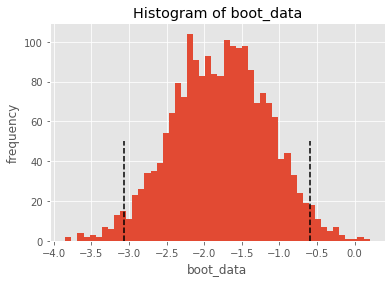

0.004772910054359527

In [38]:
# Check ARPU with full data of users

# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(money_full_A.rev, money_full_B.rev, boot_it=2000)
booted_data["p_value"]

В ARPU обнаружена стат значимая разница (p-value < 0.05)

Следовательно, отвергаем нулевую гипотезу, разница между средними чеками платящих пользователей стат.значима

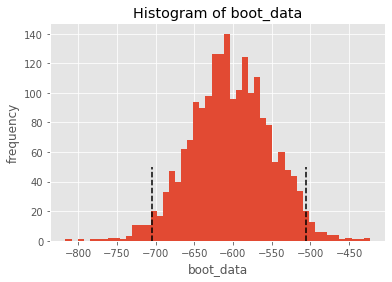

2.457026481395894e-31

In [39]:
# ARPAU

booted_data = get_bootstrap(money_A_active_no_outliers.rev, money_B_active_no_outliers.rev, boot_it=2000)
booted_data["p_value"]

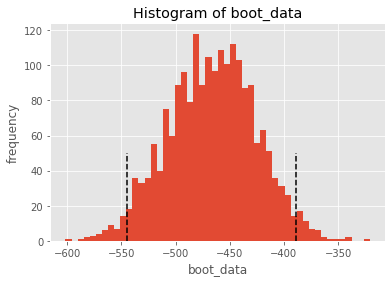

5.758204751284287e-31

In [40]:
# And check ARPPU

booted_data = get_bootstrap(money_A_no_outliers.rev, money_B_no_outliers.rev, boot_it=2000)
booted_data["p_value"]

Бутстрапом также обнаружена стат значимая разница ARPAU и ARPPU в контрольной и тестовой группе (p-value < 0.05)

Средний чек группы В выше, нулевую гипотезу отклоняем для всех трех показателей

<img src="https://qph.fs.quoracdn.net/main-qimg-b74fc57c4f52285f3e5e15cf2804c267-pjlq" width="800" height="800" />

# H0 гипотезы для конверсий:

<b>H0 - конверсии в активность, в покупку и из активности в покупку в группах А и В одинковые</b>

Проверять будем критерием хи-квадрат

In [41]:
metrics

,total_users,active_users,paying_users,money,ARPU,ARPPU,ARPAU,CR_activity,CR_purchase,CR_activity_purchase
A,14693,1538,107,92096.0000,6.268019,860.710280,59.880364,0.104676,0.007282,0.069571
B,59883,6803,434,481230.0036,8.036171,1108.824893,70.737910,0.113605,0.007247,0.063795


In [42]:
# Create np-arrays for Chi-Squared test

# CR_activity
T_CR_act = np.array([[metrics.active_users[0], metrics.total_users[0]],
                     [metrics.active_users[1], metrics.total_users[1]]])

# CR_purchase
T_CR_purch = np.array([[metrics.paying_users[0], metrics.total_users[0]],
                       [metrics.paying_users[1], metrics.total_users[1]]])

# CR_activity_purchase
T_CR_act_purch = np.array([[metrics.paying_users[0], metrics.active_users[0]],
                           [metrics.paying_users[1], metrics.active_users[1]]])

In [43]:
# P-value CR_activity
print(chi2_contingency(T_CR_act, correction=False)[1])

0.00583214228631432


In [44]:
# P-value CR_purchase
print(chi2_contingency(T_CR_purch, correction=False)[1])

0.9646145344450162


In [45]:
# P-value CR_activity_purchase
print(chi2_contingency(T_CR_act_purch, correction=False)[1])

0.43714838107439424


<b>Выводы:</b><br/>

1. Конверсия в активность среди всех пользователей выросла стат.значимо. Отвергаем H0 для CR_activity
2. Конверсия в покупку стат.значимо не отличается. Принимаем H0
3. Конверсия из активности в покупку также не отличается стат.значимо. Принимаем H0.<br/>При том, что в группе А конверсия из активности в покупку выше, отсутствие стат.значимой разницы даже хорошо :)

# ИТОГО

Средние чеки в целевой группе стали выше, причем и ARPU, и ARPAU, и ARPPU<br/>
Изменилась также конверсия в активность.<br/>
Но нет существенных различий в конверсиях в покупку и из активности в покупку

Стоит задаться вопросом, какая была цель данного A/B теста:<br/>
1) Увеличить средний чек - тогда тест успешен<br/>
2) Повлиять на конверсию - в этом случае поведение группы В не отличается от А (кроме активности)<br/>

По итогам можно сказать,<br/>
если экономика сходится (компания не тратит полученную разницу со средних чеков на кешбеки и привлечение), вариант группы В можно выкатывать на всех пользователей


# Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

<b>Задание 2.1</b><br/>
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Таблица peas

| Название атрибута      | Тип атрибута  | Смысловое значение                         |
| :---                |    :----:   |          ---:                           |
| st_id               | int         | ID ученика                                |
| timest              | timestamp   | Время решения карточки                     |
| correct             | bool        | Правильно ли решена горошина?               |
| subject             | text        | Дисциплина, в которой находится горошина      |

In [46]:
SQL_1 = """
    SELECT COUNT(DISTINCT st_id) AS Num_Diligent_Users
    FROM
    (
        SELECT
            st_id,
            COUNT(*) AS peas_solved
        FROM peas

        WHERE correct = True
          AND toMonth(timest) = 3
          AND toYear(timest)  = 2020

        GROUP BY st_id, date_trunc('hour', timest)
        HAVING COUNT(*) > 20
    )
"""

<b>Задание 2.2 Оптимизация воронки</b>

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.



Таблица studs

| Название атрибута      | Тип атрибута  | Смысловое значение                    |
| :---                |    :----:   |          ---:                      |
| st_id               | int         | ID ученика                           |
| test_grp            | text        | Метка ученика в данном эксперименте      |

Таблица checks

| Название атрибута      | Тип атрибута  | Смысловое значение                               |
| :---                |    :----:   |          ---:                                 |
| st_id               | int         | ID ученика                                     |
| sale_time           | timestamp   | Время покупки                                  |
| money               | int         | Цена, по которой приобрели данный курс             |
| subject             | text        | Дисциплина, на которую приобрели полный доступ      |

<b>Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:</b>

ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [47]:
SQL_2 = """
    SELECT
        test_grp,
        sum(ch.money) / count(DISTINCT st.st_id)                                                AS ARPU,
        sum(ch.money) / count(DISTINCT ch.st_id)                                                AS ARPAU,
        count(DISTINCT ch.st_id) / count(DISTINCT st.st_id)                                     AS CR,
        count(DISTINCT ch.st_id) / count(DISTINCT p.st_id)                                      AS CR_active,
        count(DISTINCT CASE WHEN p.subject = 'math' AND ch.subject = 'math' THEN st.st_id END) 
        / count(DISTINCT CASE WHEN p.subject = 'math' THEN st.st_id END)                        AS CR_math
    
    FROM studs st                                                        -- all users
    LEFT JOIN peas p                  ON st.st_id = p.st_id              -- active users
    LEFT JOIN checks ch               ON st.st_id = ch.st_id             -- paying users
    GROUP BY test_grp

"""

# Задание 3. Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [48]:
# Adding data from groups_add to existing groups, active_studs and checks df.
# Getting metrics data with added IDs

def groups_add_df(groups, active_studs, checks, link, sep=','):

    groups_add = get_ya_disk_df(link, sep)
    
    # Check columns and rename in case if needed   
    for i in groups_add.columns:
        if groups_add[i].dtype == 'int64':
            groups_add[i].rename('id')
            print(f"column {i} is id column\n")
        else:
            print(f"column {i} is not id column\n")
            
        if set(groups_add[i].to_list()).issubset(['A', 'B']):
            groups_add[i].rename('grp')
            print(f"column {i} is grp column\n")
        else:
            print(f"column {i} is not grp column\n")
    
    active_studs['active'] = 1
    checks['bought'] = 1
    
    # Merge groups and groups_add
    groups_full = groups.merge(groups_add, how='outer')
    # Rename id columns for merge in case if there is difference (student_id)
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)

    # Merge groups with activity. Marked 0 are non-active users
    active_full = groups_full.merge(active_studs, how='left')
    active_full.active.fillna(0, inplace=True)

    # Merge groups with checks. Mark as 0 users with no purchases
    money_full = groups_full.merge(checks, how='left')
    money_full = money_full.merge(active_studs, how='left')
    money_full.active.fillna(0, inplace=True)

    metrics = pd.DataFrame(columns=['total_users', 'active_users', 'paying_users', 'money',
                                    'ARPU', 'ARPPU', 'ARPAU', 'CR_activity', 'CR_purchase', 'CR_activity_purchase'], 
                           index=['A', 'B'])
    
    metrics['total_users'] = money_full.grp.value_counts()
    metrics['active_users'] = money_full.query('active == 1').grp.value_counts()
    metrics['paying_users'] = money_full.query('bought == 1').grp.value_counts()

    metrics['money'] = money_full.groupby('grp').rev.sum()
    metrics['ARPU'] = metrics['money'] / metrics['total_users']
    metrics['ARPPU'] = metrics['money'] / metrics['paying_users']
    metrics['ARPAU'] = metrics['money'] / metrics['active_users']

    metrics['CR_activity'] = metrics['active_users'] / metrics['total_users']
    metrics['CR_purchase'] = metrics['paying_users'] / metrics['total_users']
    metrics['CR_activity_purchase'] = metrics['paying_users'] / metrics['active_users']
    
    return metrics

In [49]:
test = groups_add_df(groups, active_studs, checks, "https://disk.yandex.ru/d/3aARY-P9pfaksg")

column id is id column

column id is not grp column

column grp is not id column

column grp is grp column



In [50]:
test

,total_users,active_users,paying_users,money,ARPU,ARPPU,ARPAU,CR_activity,CR_purchase,CR_activity_purchase
A,14693,1538,107,92096.0000,6.268019,860.710280,59.880364,0.104676,0.007282,0.069571
B,59883,6803,434,481230.0036,8.036171,1108.824893,70.737910,0.113605,0.007247,0.063795


In [51]:
def metrics_graphs(metrics):
    fig, axes = plt.subplots(6, 1, figsize=(10, 25))
    sns.barplot(ax=axes[0], data=metrics, x=metrics['ARPU'], y=metrics.index.values)
    sns.barplot(ax=axes[1], data=metrics, x=metrics['ARPPU'], y=metrics.index.values)
    sns.barplot(ax=axes[2], data=metrics, x=metrics['ARPAU'], y=metrics.index.values)
    
    sns.barplot(ax=axes[3], data=metrics, x=metrics['CR_activity'], y=metrics.index.values)
    sns.barplot(ax=axes[4], data=metrics, x=metrics['CR_purchase'], y=metrics.index.values)
    sns.barplot(ax=axes[5], data=metrics, x=metrics['CR_activity_purchase'], y=metrics.index.values)

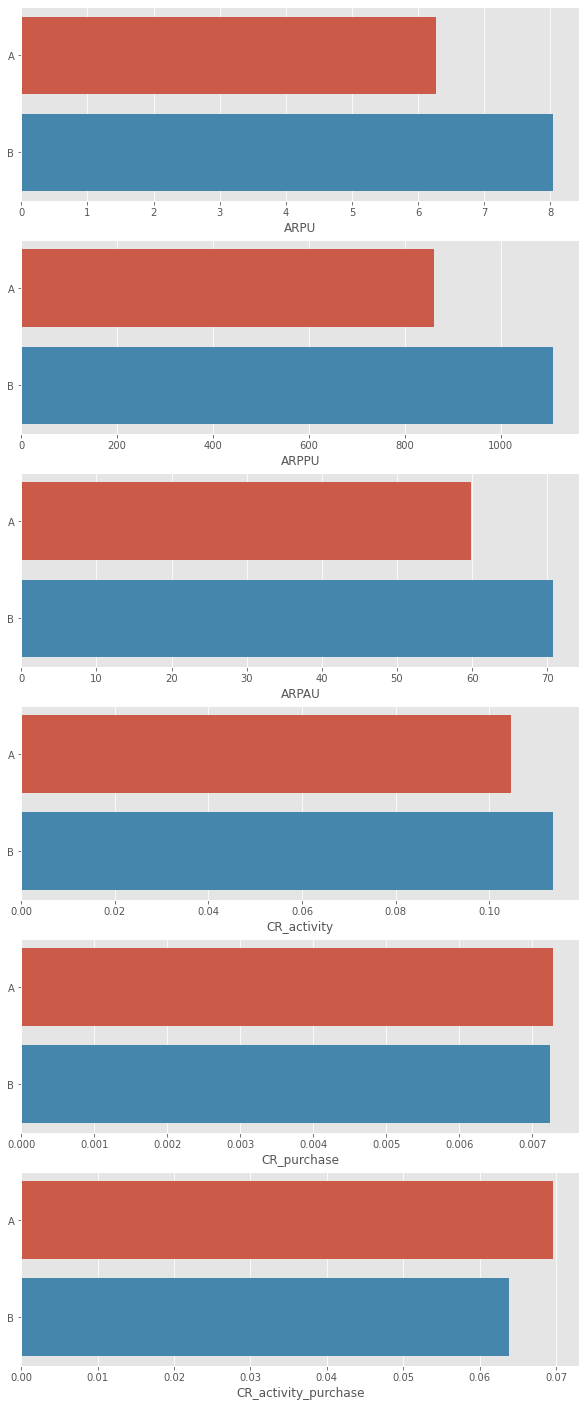

In [52]:
metrics_graphs(test)